## House Prices competition on Kaggle

The goal here is to predict the sales price for each house. For each Id in the test set we must predict the value of the SalePrice variable. 

Initial ideas:
- Train a Spline or GAM-based regression model
- Target must be log transformed
- Use MSE as evaluation metric

Changes I made for improvement:
- KNN imputer (instead of median imputer)
- Variance removal threshold set differently (0.01->0.05)
- Engineered features
- Tried PCA selection and AIC/BIC, but received worse models
- Implemented 2 different models:
	- Spline fit with Ridge regression
	- LinearGAM with smoothing splines
- Tried adaptive spline smoothing, but I had unsolved errors in the end



In [ ]:
# # For the competition we use a custom dataset
# from google.colab import files
# csv_files = files.upload()

In [ ]:
import pandas as pd

dataset_path = "/content"
train_data = pd.read_csv(f'{dataset_path}/train_competition.csv')
test_data = pd.read_csv(f'{dataset_path}/test_competition.csv')

print(train_data.head())

     Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   136          20       RL         80.0    10400   Pave   NaN      Reg   
1  1453         180       RM         35.0     3675   Pave   NaN      Reg   
2   763          60       FV         72.0     8640   Pave   NaN      Reg   
3   933          20       RL         84.0    11670   Pave   NaN      IR1   
4   436          60       RL         43.0    10667   Pave   NaN      IR2   

  LandContour Utilities  ... PoolArea PoolQC  Fence MiscFeature MiscVal  \
0         Lvl    AllPub  ...        0    NaN  MnPrv         NaN       0   
1         Lvl    AllPub  ...        0    NaN    NaN         NaN       0   
2         Lvl    AllPub  ...        0    NaN    NaN         NaN       0   
3         Lvl    AllPub  ...        0    NaN    NaN         NaN       0   
4         Lvl    AllPub  ...        0    NaN    NaN         NaN       0   

  MoSold YrSold  SaleType  SaleCondition  SalePrice  
0      5   2008        WD         Norm

In [ ]:
# Import modules
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import seaborn as sns
import matplotlib.pyplot as plt
import random

# Set reproducability
np.random.seed(42)
random.seed(42)

In [ ]:
# Checkout basic statistics
train_data.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1022.000000,1022.000000,832.000000,1022.000000,1022.000000,1022.000000,1022.000000,1022.000000,1019.000000,1022.000000,...,1022.000000,1022.000000,1022.000000,1022.000000,1022.000000,1022.000000,1022.000000,1022.000000,1022.000000,1022.000000
mean,732.338552,57.059687,70.375000,10745.437378,6.128180,5.564579,1970.995108,1984.757339,105.261040,446.176125,...,97.548924,49.525440,21.303327,3.881605,15.565558,2.743640,41.565558,6.363992,2007.814090,181312.692759
std,425.860402,42.669715,25.533607,11329.753423,1.371391,1.110557,30.748816,20.747109,172.707705,459.971174,...,131.691873,69.205968,61.534380,32.547722,56.445749,39.671531,338.132358,2.650115,1.325807,77617.461005
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,367.500000,20.000000,59.000000,7564.250000,5.000000,5.000000,1953.000000,1966.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,130000.000000
50%,735.500000,50.000000,70.000000,9600.000000,6.000000,5.000000,1972.000000,1994.000000,0.000000,390.000000,...,0.000000,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,165000.000000
75%,1100.500000,70.000000,80.000000,11692.500000,7.000000,6.000000,2001.000000,2004.000000,170.000000,724.000000,...,170.500000,73.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,215000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1378.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,8300.000000,12.000000,2010.000000,745000.000000


In [ ]:
# We can see that this dataset is smaller,
# but we have the same features as before
print(len(train_data), len(test_data))
train_data.info()

1022 438
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1022 entries, 0 to 1021
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1022 non-null   int64  
 1   MSSubClass     1022 non-null   int64  
 2   MSZoning       1022 non-null   object 
 3   LotFrontage    832 non-null    float64
 4   LotArea        1022 non-null   int64  
 5   Street         1022 non-null   object 
 6   Alley          66 non-null     object 
 7   LotShape       1022 non-null   object 
 8   LandContour    1022 non-null   object 
 9   Utilities      1022 non-null   object 
 10  LotConfig      1022 non-null   object 
 11  LandSlope      1022 non-null   object 
 12  Neighborhood   1022 non-null   object 
 13  Condition1     1022 non-null   object 
 14  Condition2     1022 non-null   object 
 15  BldgType       1022 non-null   object 
 16  HouseStyle     1022 non-null   object 
 17  OverallQual    1022 non-null   int64  
 18 

### Handling Missing Data

In [ ]:
# Identify missing data
missing_data = train_data.isnull().sum().sort_values(ascending=False)
missing_percent = (train_data.isnull().sum() / len(train_data)) * 100
missing_data = pd.concat([missing_data, missing_percent], axis=1, keys=['Total', 'Percent'])

# Display columns with missing values
print("Columns with missing values:\n", missing_data[missing_data['Total'] > 0])

Columns with missing values:
               Total    Percent
PoolQC         1017  99.510763
MiscFeature     982  96.086106
Alley           956  93.542074
Fence           820  80.234834
MasVnrType      590  57.729941
FireplaceQu     487  47.651663
LotFrontage     190  18.590998
GarageYrBlt      54   5.283757
GarageCond       54   5.283757
GarageType       54   5.283757
GarageFinish     54   5.283757
GarageQual       54   5.283757
BsmtQual         26   2.544031
BsmtCond         26   2.544031
BsmtFinType2     26   2.544031
BsmtFinType1     26   2.544031
BsmtExposure     26   2.544031
MasVnrArea        3   0.293542
Electrical        1   0.097847


In [ ]:
# Drop columns with a high percentage of missing data (e.g., more than 20% missing)
# cols_to_drop = missing_data[missing_data['Percent'] > 20].index
cols_to_drop = list(missing_data[missing_data['Percent'] > 20].index)
cols_to_drop.append('Id') # Also drop Id since its useless

train_data.drop(cols_to_drop, axis=1, inplace=True)
test_data.drop(cols_to_drop, axis=1, inplace=True)

In [ ]:
# For numerical columns with missing data, fill with median
num_cols = train_data.select_dtypes(include=['int64', 'float64']).columns.drop('SalePrice')
num_imputer = SimpleImputer(strategy='median')

# train_data[num_cols] = num_imputer.fit_transform(train_data[num_cols])
# test_data[num_cols] = num_imputer.transform(test_data[num_cols])

# Using KNN imputer instead of median imputing
n = 15 # neirest neighbours to look for
knn_num_imputer = KNNImputer(n_neighbors=n)

train_data[num_cols] = knn_num_imputer.fit_transform(train_data[num_cols])
test_data[num_cols] = knn_num_imputer.transform(test_data[num_cols])

In [ ]:
# For categorical columns with missing data, fill with the most frequent value
cat_cols = train_data.select_dtypes(include=['object']).columns
cat_imputer = SimpleImputer(strategy='most_frequent')

train_data[cat_cols] = cat_imputer.fit_transform(train_data[cat_cols])
test_data[cat_cols] = cat_imputer.transform(test_data[cat_cols])

### Feature engineering

In [ ]:
# 1. New feature: Remodelling status
# - The difference between the original construction date (YearBuilt) and the remodel/addition date (YearRemodAdd).
#   We can define a threshold to state whether the house is "recent" (recently remodelled) or "old".
train_data['Remodel_status'] = np.where((train_data['YearRemodAdd'] - train_data['YearBuilt']) <= 5, 'recent', 'old')
test_data['Remodel_status'] = np.where((test_data['YearRemodAdd'] - test_data['YearBuilt']) <= 5, 'recent', 'old')
print(train_data['Remodel_status'].value_counts())
print(test_data['Remodel_status'].value_counts())

Remodel_status
recent    705
old       317
Name: count, dtype: int64
Remodel_status
recent    302
old       136
Name: count, dtype: int64


In [ ]:
# 2. New feature: Overall status
# - Combines two variables: OverallQual (quality of materials and finish) and OverallCond (condition of the house)
#   Based on their range of values we can define a rule how to decide the Overall status
print("OverallQual: ",train_data['OverallQual'].unique())
print("OverallCond: ",train_data['OverallCond'].unique())

OverallQual:  [ 7.  5.  9.  6.  4.  8. 10.  3.  1.  2.]
OverallCond:  [6. 5. 7. 8. 3. 4. 9. 2. 1.]


In [ ]:
# Create grouping rule for Overall status
def overall_status_decesion(row):
    if row['OverallQual'] >= 8 and row['OverallCond'] >= 8:
        return 'Great'
    elif row['OverallQual'] >= 6 and row['OverallCond'] >= 6:
        return 'Good'
    elif row['OverallQual'] >= 4 and row['OverallCond'] >= 4:
        return 'Fair'
    else:
        return 'Poor'

train_data['Overall_status'] = train_data.apply(overall_status_decesion, axis=1)
test_data['Overall_status'] = test_data.apply(overall_status_decesion, axis=1)
print(train_data['Overall_status'].value_counts())
print(test_data['Overall_status'].value_counts())

Overall_status
Fair     784
Good     198
Poor      34
Great      6
Name: count, dtype: int64
Overall_status
Fair     357
Good      67
Poor      13
Great      1
Name: count, dtype: int64


In [ ]:
# Since the 'Living area features' and the 'Time related features' provided high predictive capabilities,
# regarding the target in the classification homework, it seems like worth to experiment with a new feature
# fabricated from these ones.

# Living area features
living_cols = [col for col in train_data.columns if
                ('bath' in col.lower()) or
                ('bed' in col.lower()) or
                ('garage' in col.lower()) or
                ('kitchen' in col.lower()) or
                ('room' in col.lower()) or
                ('floor' in col.lower()) or
                ('living' in col.lower())]
print(living_cols)
set_liv = set([item for col in living_cols for item in col.split('_')])
print('unique: ', len(set_liv))

# Time related faetures
time_cols = [col for col in train_data.columns if
                ('year' in col.lower()) or
                ('yr' in col.lower()) or
                ('buil' in col.lower()) or
                ('renov' in col.lower()) or
                ('date' in col.lower())]
print(time_cols)
set_time = set([item for col in time_cols for item in col.split('_')])
print('unique: ', len(set_time))


['BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond']
unique:  14
['YearBuilt', 'YearRemodAdd', 'GarageYrBlt', 'YrSold']
unique:  4


In [ ]:
# Statistic description helps identify strategies
train_data[['YearBuilt', 'YearRemodAdd', 'GarageYrBlt', 'YrSold']].describe()

,YearBuilt,YearRemodAdd,GarageYrBlt,YrSold
count,1022.000000,1022.000000,1022.000000,1022.000000
mean,1970.995108,1984.757339,1978.097978,2007.814090
std,30.748816,20.747109,24.433584,1.325807
min,1872.000000,1950.000000,1900.000000,2006.000000
25%,1953.000000,1966.000000,1961.000000,2007.000000
50%,1972.000000,1994.000000,1978.833333,2008.000000
75%,2001.000000,2004.000000,2001.000000,2009.000000
max,2010.000000,2010.000000,2010.000000,2010.000000


In [ ]:
# 3. New feature: ConstructionEra
# We can make this feature by classifying years of construction into groups
def construction_era(year):
    if year < 1900:
        return 'Before 1900'
    elif year < 1930:
        return '1900-1930'
    elif year < 1960:
        return '1930-1960'
    elif year < 1990:
        return '1960-1990'
    else:
        return '1990-2010'
train_data['ConstructionEra'] = train_data['YearBuilt'].apply(construction_era)
test_data['ConstructionEra'] = test_data['YearBuilt'].apply(construction_era)

# Check out class distribution
# (with more insight it could be more meaningful)
print(train_data['ConstructionEra'].value_counts());print()
print(test_data['ConstructionEra'].value_counts())

ConstructionEra
1990-2010      389
1960-1990      289
1930-1960      210
1900-1930      123
Before 1900     11
Name: count, dtype: int64

ConstructionEra
1990-2010      162
1960-1990      135
1930-1960       90
1900-1930       47
Before 1900      4
Name: count, dtype: int64


In [ ]:
# 4. New feature: Year features weighted
# Based on differences from current year (2010) we can make a new feature. This can be weighted as well,
# although this might manipulate the data subjectively, and perhaps not correctly.

current_year = 2010 # we saw it from statistics table of year features as max
train_data['YearFeaturesWeighted'] = (
    (current_year - train_data['YearBuilt']) * 1.0 +     # this is usually the most important among them, so deserves 100%
    (current_year - train_data['YearRemodAdd']) * 0.9 +  # this is also driving factor for buyers
    (current_year - train_data['YrSold']) * 0.6 +        # this might reflect the market status, but possibly not that influential
    (current_year - train_data['GarageYrBlt']) * 0.2     # this is usually not a driving factor
)
test_data['YearFeaturesWeighted'] = (
    (current_year - test_data['YearBuilt']) * 1.0 +
    (current_year - test_data['YearRemodAdd']) * 0.9 +
    (current_year - test_data['YrSold']) * 0.6 +
    (current_year - test_data['GarageYrBlt']) * 0.2
)

train_data['YearFeaturesWeighted'].describe() # will be rescaled, but there might be better way to normalize

,YearFeaturesWeighted
count,1022.000000
mean,69.415238
std,48.540946
min,0.000000
25%,19.575000
50%,71.050000
75%,107.700000
max,186.800000


In [ ]:
# 5. New feature: Living space
# (Living area / Total num of rooms)
# This way we might get a broader aspect about how these rooms are distributed.
train_data['LivingSpace'] = train_data['GrLivArea'] / train_data['TotRmsAbvGrd']
test_data['LivingSpace'] = test_data['GrLivArea'] / test_data['TotRmsAbvGrd']

In [ ]:
train_data['LivingSpace'].describe()

,LivingSpace
count,1022.000000
mean,232.105656
std,45.151026
min,129.000000
25%,200.312500
50%,227.083333
75%,256.428571
max,470.166667


### Encoding categorical variables


In [ ]:
# Recollect categorical columns
cat_cols = train_data.select_dtypes(include=['object']).columns.tolist()

# Inspect unique values in categorical columns
for col in cat_cols:
    print(f"{col}: {train_data[col].unique()}")

# Split into binary and multi-category columns
binary_cols = [col for col in cat_cols if train_data[col].nunique() == 2]
multi_cat_cols = [col for col in cat_cols if train_data[col].nunique() > 2]

print(f"Binary columns: {binary_cols}")
print(f"Multi-category columns: {multi_cat_cols}")

MSZoning: ['RL' 'RM' 'FV' 'C (all)' 'RH']
Street: ['Pave' 'Grvl']
LotShape: ['Reg' 'IR1' 'IR2' 'IR3']
LandContour: ['Lvl' 'HLS' 'Bnk' 'Low']
Utilities: ['AllPub' 'NoSeWa']
LotConfig: ['Inside' 'Corner' 'CulDSac' 'FR2' 'FR3']
LandSlope: ['Gtl' 'Mod' 'Sev']
Neighborhood: ['NWAmes' 'Edwards' 'Somerst' 'CollgCr' 'NAmes' 'SawyerW' 'Sawyer'
 'Gilbert' 'OldTown' 'BrkSide' 'SWISU' 'ClearCr' 'StoneBr' 'Crawfor'
 'Mitchel' 'NoRidge' 'Blmngtn' 'Veenker' 'Timber' 'IDOTRR' 'NridgHt'
 'BrDale' 'MeadowV' 'NPkVill' 'Blueste']
Condition1: ['Norm' 'RRNn' 'PosN' 'Feedr' 'PosA' 'Artery' 'RRAn' 'RRAe' 'RRNe']
Condition2: ['Norm' 'Feedr' 'RRAe' 'PosN' 'Artery' 'RRAn']
BldgType: ['1Fam' 'TwnhsE' 'Duplex' '2fmCon' 'Twnhs']
HouseStyle: ['1Story' 'SLvl' '2Story' '1.5Fin' '2.5Fin' 'SFoyer' '1.5Unf' '2.5Unf']
RoofStyle: ['Hip' 'Gable' 'Gambrel' 'Mansard' 'Flat' 'Shed']
RoofMatl: ['CompShg' 'WdShngl' 'WdShake' 'Metal' 'Tar&Grv' 'ClyTile' 'Roll']
Exterior1st: ['Plywood' 'VinylSd' 'Wd Sdng' 'MetalSd' 'HdBoard' 'BrkF

In [ ]:
# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Apply LabelEncoder to binary categorical columns
for col in binary_cols:
    train_data[col] = label_encoder.fit_transform(train_data[col])
    test_data[col] = label_encoder.transform(test_data[col])

# Check the transformed columns
print(train_data[binary_cols].head())

   Street  Utilities  CentralAir  Remodel_status
0       1          0           1               1
1       1          0           1               1
2       1          0           1               1
3       1          0           1               1
4       1          0           1               1


In [ ]:
# For multi-category variables, we use One-Hot Encoding. This creates a new binary column for each category, with 1 indicating the presence of that category and 0 otherwise.
# One-Hot Encoding using pandas get_dummies
train_data = pd.get_dummies(train_data, columns=multi_cat_cols, drop_first=True)

# Apply One-Hot Encoding to test data
test_data = pd.get_dummies(test_data, columns=multi_cat_cols, drop_first=True)

# Align the train and test datasets to have the same columns
train_data, test_data = train_data.align(test_data, join='left', axis=1, fill_value=0)

In [ ]:
len(train_data.columns), len(test_data.columns)

(235, 235)

### Standardization

In [ ]:
# Recollect numericals
num_cols = train_data.select_dtypes(include=['int64', 'float64']).columns.drop('SalePrice').tolist()

# Apply Standardization using StandardScaler
scaler = StandardScaler()
features_train = train_data.drop(columns=['SalePrice'])
features_test = test_data.drop(columns=['SalePrice'])

# Fit the scaler on the training data and transform it
features_scaled_train = scaler.fit_transform(features_train[num_cols])
features_scaled_test = scaler.fit_transform(features_test[num_cols])

# Convert the result back to a DataFrame for easy visualization
features_scaled_train = pd.DataFrame(features_scaled_train, columns=num_cols)
features_scaled_test = pd.DataFrame(features_scaled_test, columns=num_cols)

# Refreshing the dataset with scaled numerical features
for col in num_cols:
    train_data[[col]] = features_scaled_train[[col]]
    test_data[[col]] = features_scaled_test[[col]]

### Removing low variance variables

In [ ]:
## Threshold = 0.05 gave best results

print(f"Number of cols before (train): {len(train_data.columns)}")
print(f"Number of cols before (test): {len(test_data.columns)}");print()

threshold = 0.05
variances = train_data.var()
sorted_variances = variances.sort_values() # sorting them in asc
low_variance_features = variances[variances < threshold].index.tolist() # threshold low var features as <1%
train_data = train_data.drop(columns=low_variance_features) # drop low var features
test_data = test_data.drop(columns=low_variance_features) # drop low var features

print(f"Number of cols after (train): {len(train_data.columns)}")
print(f"Number of cols after (test): {len(test_data.columns)}")

Number of cols before (train): 235
Number of cols before (test): 235

Number of cols after (train): 109
Number of cols after (test): 109


## Feature selection

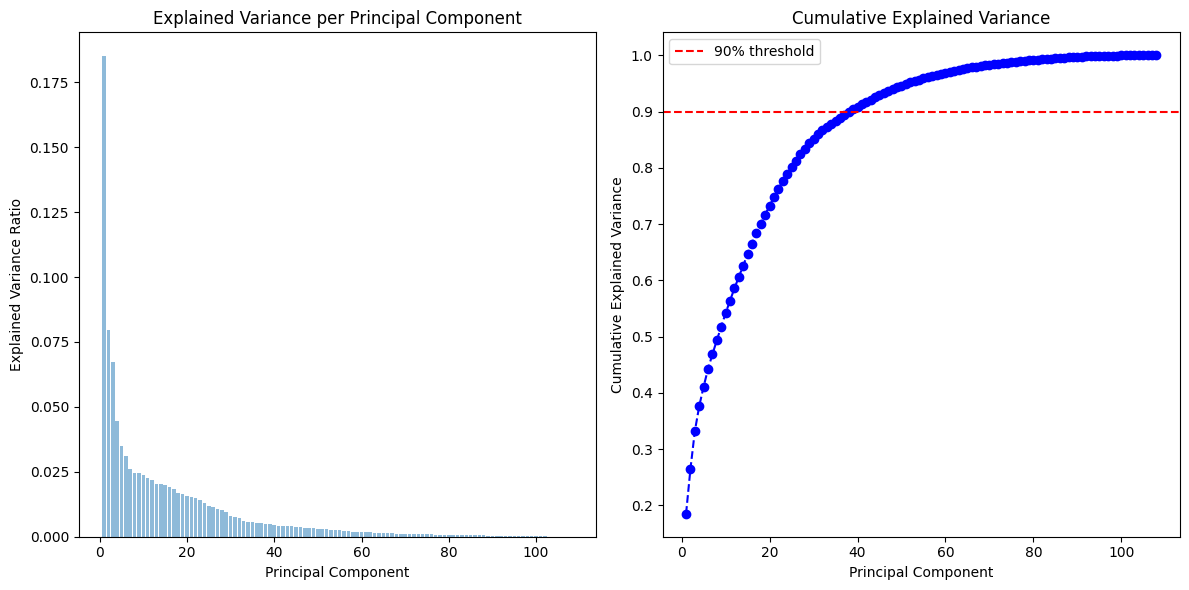


Number of components to retain 95% variance: 52


Variance ratio explained by the first 10 principal components:
PC1: 0.1850 (18.50%)
PC2: 0.0798 (7.98%)
PC3: 0.0672 (6.72%)
PC4: 0.0444 (4.44%)
PC5: 0.0348 (3.48%)
PC6: 0.0312 (3.12%)
PC7: 0.0263 (2.63%)
PC8: 0.0247 (2.47%)
PC9: 0.0245 (2.45%)
PC10: 0.0237 (2.37%)


In [ ]:
# PCA analysis
from sklearn.decomposition import PCA

# 1. Drop target from data to explore
features_reduced = train_data.drop(columns=['SalePrice'])

# 2. Apply PCA with all components, also plotting cumulative and explained variance
# Fit and transform the data with PCA
pca = PCA(n_components=None)  # Keeping all components to analyze explained variance
pca.fit(features_reduced)
pca_tr = pca.transform(features_reduced)

# Explained variance and cumulative variance
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

# Plotting explained variance and cumulative variance
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.5, align='center')
plt.ylabel('Explained Variance Ratio')
plt.xlabel('Principal Component')
plt.title('Explained Variance per Principal Component')

plt.subplot(1, 2, 2)
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--', color='b')
plt.ylabel('Cumulative Explained Variance')
plt.xlabel('Principal Component')
plt.title('Cumulative Explained Variance')
plt.axhline(y=0.90, color='r', linestyle='--', label='90% threshold')
plt.legend()

plt.tight_layout()
plt.show()


# 3. Reduce n_components to determine how many are the most descriptive ones (95% of variance)
n_components = np.argmax(cumulative_variance >= 0.95) + 1
print(f"\nNumber of components to retain 95% variance: {n_components}\n")

# 4. Apply PCA with selected number of components
pca = PCA(n_components=n_components)
features_pca_reduced = pca.fit_transform(features_reduced)

# 5. Get the explained variance ratio for each PC
explained_variance_ratio = pca.explained_variance_ratio_
print("\nVariance ratio explained by the first 10 principal components:")
for i in range(10):
    pc = f'PC{i+1}'
    variance_ratio = explained_variance_ratio[i]
    print(f"{pc}: {variance_ratio:.4f} ({variance_ratio * 100:.2f}%)")


In [ ]:
# Create df from pca results
loadings = pd.DataFrame(pca.components_.T, columns=[f'PC{i+1}' for i in range(pca.n_components_)],
                            index=features_reduced.columns)

In [ ]:
## PCA selection approach:
# Set a threshold for absolute loading values (0.4) and select features from all PCA over the threshold.

threshold = 0.35
pca_selection_features = []

for i in range(pca.n_components_):
    pc = f'PC{i+1}'
    component_loadings = loadings[pc].abs() # take a pc
    th_applied_features = component_loadings[component_loadings > threshold].index.tolist() # apply threshold
    pca_selection_features.extend(th_applied_features)

pca_selection_features = list(set(pca_selection_features))
print(f'PCA selected features:\n {pca_selection_features}\n{len(pca_selection_features)}')


PCA selected features:
 ['HeatingQC_Gd', 'ExterCond_Gd', 'ScreenPorch', 'KitchenAbvGr', 'GarageCars', '3SsnPorch', 'GarageFinish_RFn', 'MiscVal', 'MSSubClass', 'MoSold', 'CentralAir', 'ExterCond_TA', 'GarageYrBlt', 'BsmtExposure_No', 'HalfBath', 'EnclosedPorch', 'YrSold', 'BsmtFinSF2', 'BsmtHalfBath', 'LowQualFinSF', 'OverallQual', 'LotConfig_Inside', 'Fireplaces', 'LivingSpace', 'WoodDeckSF', 'OverallCond', 'PoolArea', 'LotShape_Reg', 'Street', 'OpenPorchSF', 'LotArea', 'MasVnrArea', 'GarageArea', 'LotFrontage', 'Remodel_status', 'BsmtUnfSF']
36


Optimal number of features based on AIC: 32
Selected features based on AIC: ['HeatingQC_Gd', 'ExterCond_Gd', 'ScreenPorch', 'KitchenAbvGr', 'GarageCars', '3SsnPorch', 'GarageFinish_RFn', 'MiscVal', 'MSSubClass', 'MoSold', 'CentralAir', 'ExterCond_TA', 'GarageYrBlt', 'BsmtExposure_No', 'HalfBath', 'EnclosedPorch', 'YrSold', 'BsmtFinSF2', 'BsmtHalfBath', 'LowQualFinSF', 'OverallQual', 'LotConfig_Inside', 'Fireplaces', 'LivingSpace', 'WoodDeckSF', 'OverallCond', 'PoolArea', 'LotShape_Reg', 'Street', 'OpenPorchSF', 'LotArea', 'MasVnrArea']
Optimal number of features based on BIC: 32
Selected features based on BIC: ['HeatingQC_Gd', 'ExterCond_Gd', 'ScreenPorch', 'KitchenAbvGr', 'GarageCars', '3SsnPorch', 'GarageFinish_RFn', 'MiscVal', 'MSSubClass', 'MoSold', 'CentralAir', 'ExterCond_TA', 'GarageYrBlt', 'BsmtExposure_No', 'HalfBath', 'EnclosedPorch', 'YrSold', 'BsmtFinSF2', 'BsmtHalfBath', 'LowQualFinSF', 'OverallQual', 'LotConfig_Inside', 'Fireplaces', 'LivingSpace', 'WoodDeckSF', 'OverallC

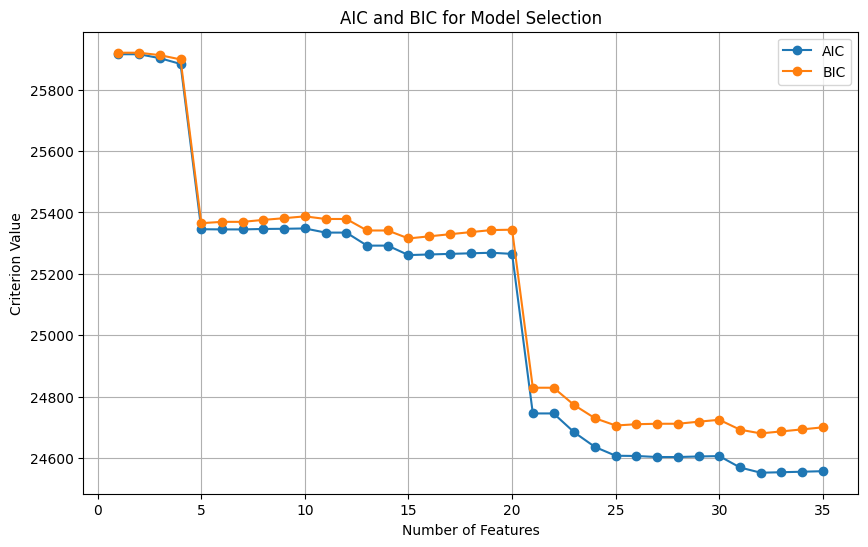

In [ ]:
# Apply multiple regression tests to calculate AIC/BIC values
# and make feature selection based on it
import statsmodels.api as sm

# Ensure target variable 'y' is numeric
y = pd.to_numeric(train_data['SalePrice'], errors='coerce')

# Store AIC and BIC values for each model
aic_values = []
bic_values = []

# Incrementally add features and calculate AIC and BIC
for i in range(1, len(pca_selection_features)):
    # Select the top `i` features
    selected_features = pca_selection_features[:i]

    X = features_reduced[selected_features]
    X = X.select_dtypes(include=[np.number])  # Remove non-numeric columns

    # Add a constant to the model for the intercept term
    X = sm.add_constant(X)
    # Fit an OLS regression model and calculate AIC and BIC
    model = sm.OLS(y, X, missing='drop').fit()  # Use missing='drop' to handle NaNs
    aic_values.append(model.aic)
    bic_values.append(model.bic)

# Find the optimal number of features based on minimum AIC and BIC
optimal_features_aic = pca_selection_features[:np.argmin(aic_values) + 1]
optimal_features_bic = pca_selection_features[:np.argmin(bic_values) + 1]

print("Optimal number of features based on AIC:", len(optimal_features_aic))
print("Selected features based on AIC:", optimal_features_aic)

print("Optimal number of features based on BIC:", len(optimal_features_bic))
print("Selected features based on BIC:", optimal_features_bic)

# Plot AIC and BIC values for each model to visualize the selection
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(aic_values) + 1), aic_values, label='AIC', marker='o')
plt.plot(range(1, len(bic_values) + 1), bic_values, label='BIC', marker='o')
plt.xlabel('Number of Features')
plt.ylabel('Criterion Value')
plt.title('AIC and BIC for Model Selection')
plt.legend()
plt.grid(True)
plt.show()

## Model training

- Implemented 2 different models:
	- Spline fit with Ridge regression
	- LinearGAM with smoothing splines
- Tried adaptive spline smoothing, but I had unsolved errors in the end



In [ ]:
!pip install pygam

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV, ParameterGrid
from sklearn.metrics import mean_squared_error, r2_score, mean_squared_log_error, root_mean_squared_log_error
from sklearn.preprocessing import SplineTransformer
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.pipeline import Pipeline
from scipy.interpolate import UnivariateSpline

from pygam import LinearGAM, s
from pygam.terms import TermList

In [ ]:
# Using custom competition data for training and test
# (also log transform target to handle skewness)

# X_train = train_data[pca_selection_features]
X_train = train_data.drop(columns=['SalePrice'])
y_train = np.log1p(train_data['SalePrice']) # log1p handles log(0) cases by computing log(1 + x)

# X_test = test_data[pca_selection_features]
X_test = test_data.drop(columns=['SalePrice'])
y_test = np.log1p(test_data['SalePrice'])

# Check data shape
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (1022, 108), y_train shape: (1022,)
X_test shape: (438, 108), y_test shape: (438,)


In [ ]:
## I started to apply adaptive spline smoothing to features, but
## I had issues with, and could not identify what went wrong.

# def smooth_features_adaptive(X, y, weights):
#     """
#     Smooth features using UnivariateSpline with adaptive weights.
#     """
#     smoothed_X = np.zeros_like(X)
#     for i in range(X.shape[1]):
#         # Sort the data by the feature values
#         sorted_indices = np.argsort(X[:, i])
#         x_sorted = X[sorted_indices, i]
#         y_sorted = y[sorted_indices]
#         weights_sorted = weights[sorted_indices]

#         # Fit the spline with sorted data
#         spline = UnivariateSpline(x_sorted, y_sorted, w=weights_sorted)
#         smoothed_X[:, i] = spline(X[:, i])  # Evaluate the spline on the original feature values
#     return smoothed_X

# # Smooth the features with adaptive weights
# adaptive_s = 1 / (1 + np.abs(y_train - np.median(y_train)))
# X_smoothed_adaptive = smooth_features_adaptive(X_train.values, y_train.values, adaptive_s)

In [ ]:
# ------ Spline fitting and Ridge regression --------

# Define a pipeline with spline transformation and ridge regression
pipeline = Pipeline([
    ('spline', SplineTransformer(include_bias=False)),  # Apply spline transformation
    ('ridge', Ridge())  # Ridge regression on transformed data
])

# Set up the parameter grid
param_grid = {
    'spline__n_knots': [3, 5, 7, 9, 11, 13, 15],  # Varying the number of knots for each feature
    'spline__degree': [2, 3],         # Test quadratic and cubic splines
    'ridge__alpha': [0.01, 0.1, 1, 10, 100]  # Regularization parameter
}

# Perform grid search cross-validation to find the best hyperparameters
grid_search = GridSearchCV(pipeline, param_grid, scoring='neg_root_mean_squared_log_error', cv=5)
grid_search.fit(X_train, y_train)

# Get the best model and its parameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

# Use the best model to make predictions
y_pred_optimized = best_model.predict(X_test)

# Compute performance metrics
mse_optimized_spline = mean_squared_error(y_test, y_pred_optimized)
rmsle_optimized_spline = root_mean_squared_log_error(y_test, y_pred_optimized)
r2_optimized_spline = r2_score(y_test, y_pred_optimized)

# Display results
print("Best Parameters:", best_params)
print("Optimized Spline Model MSE:", mse_optimized_spline)
print("Optimized Spline Model RMSLE:", rmsle_optimized_spline)
print("Optimized Spline Model R2:", r2_optimized_spline)

Best Parameters: {'ridge__alpha': 10, 'spline__degree': 2, 'spline__n_knots': 5}
Optimized Spline Model MSE: 0.017435501137435173
Optimized Spline Model RMSLE: 0.010373513670854448
Optimized Spline Model R2: 0.8972229661747989


In [ ]:
# ------ Linear GAM with Smoothing Splines --------

# Create LinearGAM with smoothing splines of given amount of features
num_of_features = X_train.shape[1] - 1
spline_terms = TermList(*[s(i) for i in range(num_of_features)]) # splines for each feature
gam = LinearGAM(spline_terms)

# (The module's gridsearch method did not work properly having cloning issues, so I replaced this optionally with ParameterGrid)
gam_params = {'lam': [0.01, 0.1, 1, 10, 100], 'n_splines': [5, 10, 15, 20]}  # Grid search over lambda and n_splines

# Track best metrics
best_gam = None
best_gam_mse = float('inf')
best_gam_rmsle = float('inf')
best_r2 = float('inf')

# Using ParameterGrid to manually iterate over parameter combinations for GAM
for params in ParameterGrid(gam_params):
    gam.set_params(**params)  # Set the current parameter combination
    gam.fit(X_train, y_train)  # Fit the model

    # Make prediction with LinearGAM
    y_pred = gam.predict(X_test)

    # Evaluate the predictions on metrics
    mse = mean_squared_error(y_test, y_pred)
    rmsle = root_mean_squared_log_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Track best metrics
    if mse < best_gam_mse:
        best_gam_mse = mse
        best_gam_rmsle = rmsle
        best_gam = gam
        best_r2 = r2

# Print results for GAM with smoothing splines
print(f"Best GAM model MSE (with smoothing splines): {best_gam_mse:.4f}")
print(f"Best GAM model RMSLE (with smoothing splines): {best_gam_rmsle:.4f}")
print(f"Best GAM model R2 (with smoothing splines): {best_r2:.4f}")


Best GAM model MSE (with smoothing splines): 0.0173
Best GAM model RMSLE (with smoothing splines): 0.0103
Best GAM model R2 (with smoothing splines): 0.8979


In [ ]:
# Combined results
results = {
    "Model": ["Spline model", "LinearGAM"],
    "MSE": [mse_optimized_spline, best_gam_mse],
    "RMSLE": [rmsle_optimized_spline, best_gam_rmsle],
    "R2": [r2_optimized_spline, best_r2]
}

# Print combined results
print("Combined Results:")
print(pd.DataFrame(results))

Combined Results:
          Model       MSE     RMSLE        R2
0  Spline model  0.017436  0.010374  0.897223
1     LinearGAM  0.017323  0.010306  0.897885


In [ ]:
# Got different results for PCA selection and the whole dataset:

# With PCA selection (52 features with 95% of explained variance):
# Combined Results:
#           Model       MSE     RMSLE        R2
# 0  Spline model  0.018828  0.010750  0.889012
# 1     LinearGAM  0.018567  0.010665  0.890551

# All features (109 features):
# Combined Results:
#           Model       MSE     RMSLE        R2
# 0  Spline model  0.017436  0.010374  0.897223
# 1     LinearGAM  0.017323  0.010306  0.897885
